High Performance Python
=======

Lecture 7. Numba
----------

Heavily based on (forked): 

Scipy2017 tutorial by Gil Forsyth:

https://github.com/gforsyth/numba_tutorial_scipy2017

https://www.youtube.com/watch?v=1AwG0T4gaO0&t=1349s

GTC2018 tutorial by Stan Seibert:

https://github.com/ContinuumIO/gtc2018-numba


High Performance Python
----------------------

* multiprocessing
* mpi4py
* pycuda
* cupy
* pyopencl
* **numba**

Numba is:

Just-In-Time (JIT) compiler:
* generates optimized machine code using LLVM
* integrates well with Scientific Python stack
* **function compiler**: Numba compiles Python functions (not entire applications and not parts of functions). Numba is a Python module.
* **type-specializing**: Numba speeds up your function by generating a specialized implementation for the specific data types you are using. 
* **just-in-time**: Numba translates functions when they are first called so that the compiler knows the argument types. Works in Jupyter notebook.
* **numerically-focused**: „mostly“ int, float, complex. Works good with numpy arrays.


The first step is always to find the bottlenecks in your code, via _profiling_: analyzing your code by measuring the execution time of its parts.


Tools:
------

2. `cProfile`
4. `snakeviz`
1. [`line_profiler`](https://github.com/rkern/line_profiler)
3. `timeit`



```console
pip install line_profiler
```

In [1]:
import numpy
from time import sleep

def sleepy(time2sleep):
    sleep(time2sleep)
    
def supersleepy(time2sleep):
    sleep(time2sleep)
    
def randmatmul(n=1000):
    a = numpy.random.random((n,n))
    b = a @ a
    return b
    
def useless(a):
    if not isinstance(a, int):
        return
    
    randmatmul(a)
    
    ans = 0
    for i in range(a):
        ans += i
        
    sleepy(1.0)
    supersleepy(2.0)
        
    return ans

## using `cProfile`

[`cProfile`](https://docs.python.org/3.4/library/profile.html#module-cProfile) is the built-in profiler in Python (available since Python 2.5).  It provides a function-by-function report of execution time. First import the module, then usage is simply a call to `cProfile.run()` with your code as argument. It will print out a list of all the functions that were called, with the number of calls and the time spent in each.


In [2]:
import cProfile

cProfile.run('useless(3000)')

         11 function calls in 3.739 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.642    0.642    0.727    0.727 <ipython-input-1-3d4635a3d65c>:10(randmatmul)
        1    0.012    0.012    3.739    3.739 <ipython-input-1-3d4635a3d65c>:15(useless)
        1    0.000    0.000    1.000    1.000 <ipython-input-1-3d4635a3d65c>:4(sleepy)
        1    0.000    0.000    2.001    2.001 <ipython-input-1-3d4635a3d65c>:7(supersleepy)
        1    0.000    0.000    3.739    3.739 <string>:1(<module>)
        1    0.000    0.000    3.739    3.739 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        2    3.000    1.500    3.000    1.500 {built-in method time.sleep}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.085    0.085    0.085    0.085 {method 'random' of 'numpy.random.mtrand.RandomS

## using `snakeviz`

In [3]:
%load_ext snakeviz

In [4]:
%snakeviz useless(3000)

 
*** Profile stats marshalled to file 'C:\\Users\\Admin\\AppData\\Local\\Temp\\tmp8ehqpajj'. 
Embedding SnakeViz in this document...


## using `line_profiler`

`line_profiler` offers more granular information than `cProfile`: it will give timing information about each line of code in a profiled function.

### For a pop-up window with results in notebook:

IPython has an `%lprun` magic to profile specific functions within an executed statement. Usage:
`%lprun -f func_to_profile <statement>` (get more help by running `%lprun?` in IPython).

In [5]:
%load_ext line_profiler
%lprun -f sleepy -f supersleepy useless(1000)

### Write results to a text file

In [6]:
%lprun -T timings.txt -f sleepy useless(1000)


*** Profile printout saved to text file 'timings.txt'. 


## Profiling on the command line

Open file, add `@profile` decorator to any function you want to profile, then run

```console
kernprof -l script_to_profile.py
```

which will generate `script_to_profile.py.lprof` (pickled result).  To view the results, run

```console
python -m line_profiler script_to_profile.py.lprof
```

In [7]:
from IPython.display import IFrame
IFrame('http://localhost:8888/terminals/1', width=800, height=700)

## `timeit`

```python
python -m timeit "print(42)"
```


In [8]:
# line magic
%timeit x=10

11.6 ns ± 1.11 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [9]:
%%timeit 
# cell magic

x=10
a='hello'
d=[1,2,3]

51.2 ns ± 3.29 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


JIT
===

### Array sum

The function below is a naive `sum` function that sums all the elements of a given array.

In [10]:
def sum_array(inp):
    J, I = inp.shape
    
    #this is a bad idea
    mysum = 0
    for j in range(J):
        for i in range(I):
            mysum += inp[j, i]
            
    return mysum

In [11]:
import numpy
arr = numpy.random.random((300, 300))

sum_array(arr)

plain = %timeit -o sum_array(arr)

16.4 ms ± 762 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
from numba import jit

sum_array_numba = jit()(sum_array)

sum_array_numba(arr)

jitted = %timeit -o sum_array_numba(arr)

plain.best / jitted.best


91.4 µs ± 255 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


168.98017087260996

## More commonly as a decorator

In [13]:
@jit
def sum_array(inp):
    I, J = inp.shape
    
    mysum = 0
    for i in range(I):
        for j in range(J):
            mysum += inp[i, j]
            
    return mysum

In [14]:
%timeit arr.sum()

33.3 µs ± 1.42 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Exercise 1. JIT the Mandelbrot fractal
--------------------------------------------

Separate exercise notebook or use your own Mandelbrot code 

1. Profile the code, find the bottlenecks
2. Use Numba to speed up the code
3. Compare the timing

## 14.2
Numba usage - enabling of `jit` decorator

In [89]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np


from numba import jit


def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255


def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

@jit
def mandel_numba(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@jit
def create_fractal_numba(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel_numba(real, imag, iters)
            image[y, x] = color

    return image

# image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
# s = timer()
# create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
# e = timer()
# print(e - s)


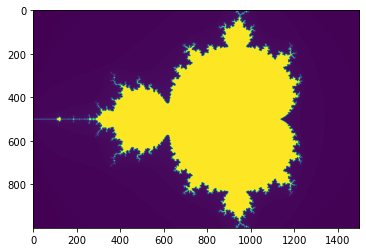

In [90]:
import matplotlib.pyplot as plt
plt.imshow(create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20))
plt.show()

## 14.1

In [27]:
%lprun -f mandel -f create_fractal create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)

We can see that the almost all the time goes for `mandel` function computation. Inside of it the main time consumers are line inside of a loop. Can we accelerate that?

## 14.3

In [28]:
# without jit decorator
image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
s = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
e = timer()
print(e - s)

5.115781800000036


In [93]:
# with jit decorator
image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
s = timer()
create_fractal_numba(-2.0, 1.0, -1.0, 1.0, image, 20)
e = timer()
print(e - s)

0.046895899999071844


Yes, we can! Using `numba` we accelerated computation in approximately 25 times.

## 14.4

In [94]:
np_results = []
numba_results = []
iterations = (10, 20, 50, 100, 1000)
for max_iter in iterations:
    image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
    
    np_time = %timeit -oq create_fractal(-2.0, 1.0, -1.0, 1.0, image, max_iter)
    
    image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
   
    numba_time = %timeit -oq create_fractal_numba(-2.0, 1.0, -1.0, 1.0, image, max_iter)
    
    np_results.append(np_time.best)
    numba_results.append(numba_time.best)

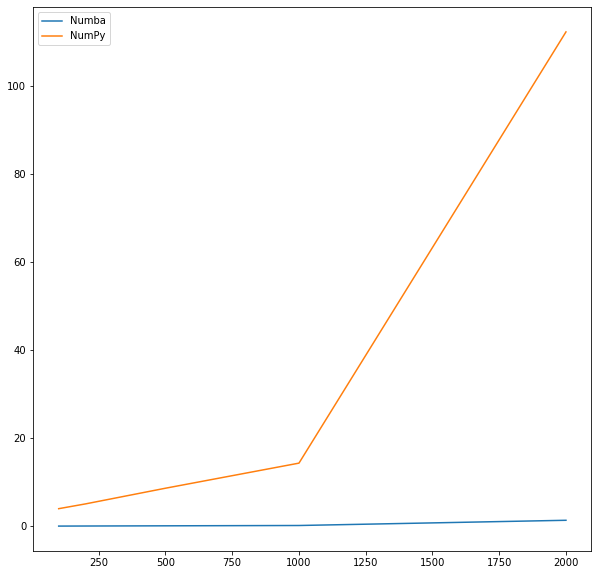

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
plt.plot(sizes, numba_results, label = 'Numba')
plt.plot(sizes, np_results, label = 'NumPy')
plt.legend()
plt.show()

In [32]:
@jit
def add(a, b):
    return a + b

In [33]:
add(1, 1)

2

Numba examines Python bytecode and then translates this into an 'intermediate representation'.  To view this IR, run (compile) `add` and you can access the `inspect_types` method.

In [34]:
add.inspect_types()

add (int64, int64)
--------------------------------------------------------------------------------
# File: <ipython-input-32-7a2ac56f16b6>
# --- LINE 1 --- 

@jit

# --- LINE 2 --- 

def add(a, b):

    # --- LINE 3 --- 
    # label 0
    #   a = arg(0, name=a)  :: int64
    #   b = arg(1, name=b)  :: int64
    #   $6binary_add.2 = a + b  :: int64
    #   del b
    #   del a
    #   $8return_value.3 = cast(value=$6binary_add.2)  :: int64
    #   del $6binary_add.2
    #   return $8return_value.3

    return a + b




Ok.  Numba is has correctly inferred the type of the arguments, defining things as `int64` and running smoothly.  

(What happens if you do `add(1., 1.)` and then `inspect_types`?)

In [35]:
add(1.,1.)

2.0

In [36]:
add.inspect_types()

add (int64, int64)
--------------------------------------------------------------------------------
# File: <ipython-input-32-7a2ac56f16b6>
# --- LINE 1 --- 

@jit

# --- LINE 2 --- 

def add(a, b):

    # --- LINE 3 --- 
    # label 0
    #   a = arg(0, name=a)  :: int64
    #   b = arg(1, name=b)  :: int64
    #   $6binary_add.2 = a + b  :: int64
    #   del b
    #   del a
    #   $8return_value.3 = cast(value=$6binary_add.2)  :: int64
    #   del $6binary_add.2
    #   return $8return_value.3

    return a + b


add (float64, float64)
--------------------------------------------------------------------------------
# File: <ipython-input-32-7a2ac56f16b6>
# --- LINE 1 --- 

@jit

# --- LINE 2 --- 

def add(a, b):

    # --- LINE 3 --- 
    # label 0
    #   a = arg(0, name=a)  :: float64
    #   b = arg(1, name=b)  :: float64
    #   $6binary_add.2 = a + b  :: float64
    #   del b
    #   del a
    #   $8return_value.3 = cast(value=$6binary_add.2)  :: float64
    #   del $6binary_ad

### What about the actual LLVM code?

You can see the actual LLVM code generated by Numba using the `inspect_llvm()` method.  Since it's a `dict`, doing the following will be slightly more visually friendly.

In [37]:
for k, v in add.inspect_llvm().items():
    print(k, v)

(int64, int64) ; ModuleID = 'add'
source_filename = "<string>"
target datalayout = "e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-pc-windows-msvc"

@"_ZN08NumbaEnv8__main__7add$249Exx" = common local_unnamed_addr global i8* null
@.const.add = internal constant [4 x i8] c"add\00"
@PyExc_RuntimeError = external global i8
@".const.missing Environment: _ZN08NumbaEnv8__main__7add$249Exx" = internal constant [55 x i8] c"missing Environment: _ZN08NumbaEnv8__main__7add$249Exx\00"

; Function Attrs: nofree norecurse nounwind writeonly
define i32 @"_ZN8__main__7add$249Exx"(i64* noalias nocapture %retptr, { i8*, i32, i8* }** noalias nocapture readnone %excinfo, i64 %arg.a, i64 %arg.b) local_unnamed_addr #0 {
entry:
  %.14 = add nsw i64 %arg.b, %arg.a
  store i64 %.14, i64* %retptr, align 8
  ret i32 0
}

define i8* @"_ZN7cpython8__main__7add$249Exx"(i8* nocapture readnone %py_closure, i8* %py_args, i8* nocapture readnone %py_kws) local_unnamed_add

## But there's a caveat
Now, watch what happens when we try to do something that is natural in Python, but not particularly mathematically sound:

In [38]:
from numba import njit

In [39]:
def add_strings(a, b):
    return a + b

In [40]:
add_strings_jit = njit()(add_strings)

In [41]:
add_strings_jit('a', 'b')

'ab'

In [42]:
add_strings_jit.inspect_types()

add_strings (unicode_type, unicode_type)
--------------------------------------------------------------------------------
# File: <ipython-input-39-d1008a9d4aa2>
# --- LINE 1 --- 

def add_strings(a, b):

    # --- LINE 2 --- 
    # label 0
    #   a = arg(0, name=a)  :: unicode_type
    #   b = arg(1, name=b)  :: unicode_type
    #   $6binary_add.2 = a + b  :: unicode_type
    #   del b
    #   del a
    #   $8return_value.3 = cast(value=$6binary_add.2)  :: unicode_type
    #   del $6binary_add.2
    #   return $8return_value.3

    return a + b




### Compiler options

```python
cache=True
```

if you don't want to always want to get dinged by the compilation time for every run. This will actually save the compiled function into something like a `pyc` file in your `__pycache__` directory, so even between sessions you should have nice fast performance.

## N-Body problems

Many physical problems require the evaluation of all pairwise interactions of a large number of particles, so-called N-body problems. These problems arise in molecular dynamics, astrodynamics and electromagnetics among others. 

Their pairwise interactions can be expressed as:

\begin{equation}
f_i = \sum_{j=1}^n{P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)w_j} \ \ \ \text{for } i=1,2,...,n 
\end{equation}

*  where subscripts $i$,  $j$ respectively denote *target* and *source*
*  $f_i$ can be a *potential* (or *force*) at target point $i$
*  $w_j$ is the *source weight* 
*  $\boldsymbol{x}_i, \boldsymbol{x}_j$ are the *spatial positions* of particles 
*  $P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)$ is the *interaction kernel*. 

In order to evalute the potential $f_i$ at a target point $i$, we have to loop over each source particle $j$. Since there are $n$ target points $i$, this 'brute-force' approach costs $\mathcal{O} \left(n^2 \right)$ operations. 

One possible approach in this kind of problem is to define a few classes, say `Point` and `Particle` and then loop over the objects and perform the necessary point-to-point calculations.

In [43]:
class Point():
    """    
    Arguments:
        domain: the domain of random generated coordinates x,y,z, 
                default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    def __init__(self, domain=1.0):
        self.x = domain * numpy.random.random()
        self.y = domain * numpy.random.random()
        self.z = domain * numpy.random.random()
            
    def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5

In [44]:
class Particle(Point):
    """    
    Attributes:
        m: mass of the particle
        phi: the potential of the particle
    """
    
    def __init__(self, domain=1.0, m=1.0):
        Point.__init__(self, domain)
        self.m = m
        self.phi = 0.

Now we create a list of `n` random particles, define a function to calculate their interaction via direct summation and run!

In [45]:
n = 1000
particles = [Particle(m = 1 / n) for i in range(n)]

In [46]:
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

In [47]:
direct_sum(particles)

In [48]:
orig_time = %timeit -o direct_sum(particles)

1.06 s ± 34.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [50]:
%lprun -f direct_sum direct_sum(particles)

## How do we use Numba on this problem?
Problem: Numba doesn't support jitting native Python classes.  There is a `jit_class` structure in Numba but it's still in early development.

But it's nice to have attributes for literate programming.

Solution: NumPy custom dtypes.

In [51]:
particle_dtype = numpy.dtype({'names':['x','y','z','m','phi'], 
                             'formats':[numpy.double, 
                                        numpy.double, 
                                        numpy.double, 
                                        numpy.double, 
                                        numpy.double]})

In [52]:
myarray = numpy.ones(3, dtype=particle_dtype)

In [53]:
myarray

array([(1., 1., 1., 1., 1.), (1., 1., 1., 1., 1.), (1., 1., 1., 1., 1.)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('phi', '<f8')])

In [54]:
myarray[0]['x'] = 2.0

In [61]:
myarray[:]['x'] = 1 * numpy.random.random()

In [62]:
myarray

array([(0.58608099, 1., 1., 1., 1.), (0.58608099, 1., 1., 1., 1.),
       (0.58608099, 1., 1., 1., 1.)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('phi', '<f8')])

### Exercise 1

Write a function `create_n_random_particles` that takes the arguments `n` (number of particles), `m` (mass of every particle) and a domain within to generate a random number (as in the class above).
It should create an array with `n` elements and `dtype=particle_dtype` and then return that array.

For each particle, the mass should be initialized to the value of `m` and the potential `phi` initialized to zero.

For the `x` component of a given particle `p`, you might do something like

```python
p['x'] = domain * numpy.random.random()
```

## 15.1

In [66]:
@njit
def create_n_random_particles(n, m, domain=1):
    '''
    Creates `n` particles with mass `m` with random coordinates
    between 0 and `domain`
    '''
    parts = numpy.zeros((n), dtype=particle_dtype)
    for i, _ in enumerate(parts):
        parts[i]['x'] = domain * numpy.random.random()
        parts[i]['y'] = domain * numpy.random.random()
        parts[i]['z'] = domain * numpy.random.random()
        parts[i]['m'] = m
    
    

    ### your code
    ### your code
    ### your code
    
    return parts   #parts is an array of particles

In [67]:
# test it
parts = create_n_random_particles(1000, .001, 1)

### Exercise 2

Write a JITted function `distance` to calculate the distance between two particles of dtype `particle_dtype`

Here's the `distance` method from the `Particle` class as a reference:

```python
def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5
```

In [68]:
@jit
def distance(part1, part2):
    '''calculate the distance between two particles'''
    return ((part1['x'] - part2['x'])**2 + 
                (part1['y'] - part2['y'])**2 + 
                (part1['z'] - part2['z'])**2)**.5
    # your code here

In [70]:
# test it

distance(parts[0], parts[1])

1.1568700455446095

### Exercise 3
Modify the original `direct_sum` function (copied below for reference) to instead work a NumPy array of particles.  Loop over each element in the array and calculate its total potential.

```python
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

## 15.2

In [80]:
@jit
def direct_sum(particles):
    for i, target in enumerate(particles):
        for j, source in enumerate(particles):
            if j == i:
                continue
            r = distance(target, source)
            particles[i]['phi'] += source['m'] / r

In [76]:
direct_sum(parts)

## 15.3

In [87]:
def direct_sum_np(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r
np_results = []
numba_results = []
sizes = (100, 200, 500, 1000, 2000)
for n in sizes:
    particles = [Particle(m = 1 / n) for i in range(n)]
    np_time = %timeit -oq direct_sum_np(particles)
    
    parts = create_n_random_particles(n, 1/n, 1)   
    numba_time = %timeit -oq direct_sum(parts)
    
    np_results.append(np_time.best)
    numba_results.append(numba_time.best)

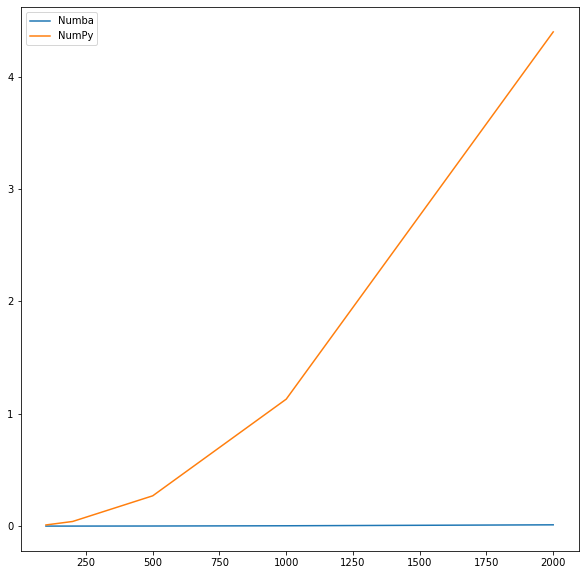

In [88]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
plt.plot(sizes, numba_results, label = 'Numba')
plt.plot(sizes, np_results, label = 'NumPy')
plt.legend()
plt.show()